In [1]:
import os
import sys

import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
sns.set(style='whitegrid', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

from utils import compare
from envs import TwoPeakEnv

In [2]:
def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

In [3]:
env = TwoPeakEnv(noise_std=0.001)
# We only do one repeat run here, because the convergence pattern is deterministic
# (caused by the aggregated gradient direction)
data_gaussian = compare(env, 'gaussian', n_steps=10, repeats=1,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=20)
data_gaussian['mean'] = data_gaussian['pd_param_0_mean']
data_gaussian['std'] = data_gaussian['pd_param_1_mean']

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env = TwoPeakEnv(noise_std=0.001)
data_beta = compare(env, 'beta', n_steps=10, repeats=1,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=20)
a = data_beta['pd_param_0_mean']
b = data_beta['pd_param_1_mean']
low = env.action_space.low
high = env.action_space.high
data_beta['mean'] = a / (a + b)
data_beta['mean'] = data_beta['mean'] * (high-low) + low

In [5]:
def get_two_peak_reward(action):  
    reward = 1.1 * np.exp(-1.2*np.power(action-(-2), 2)) + 0.9 * np.exp(-0.9*np.power(action-(1), 2))
    return reward

In [6]:
%matplotlib inline

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


3.1045939361807724


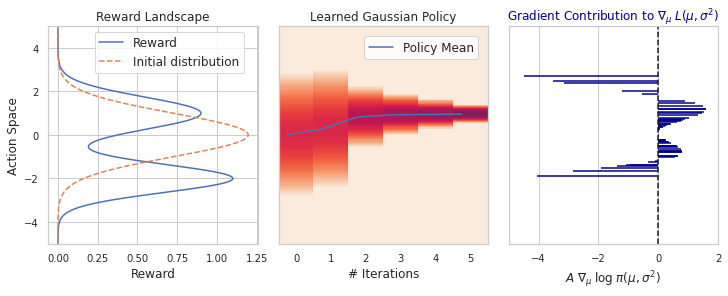

In [7]:
from scipy.stats import norm
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
y1 = -5
y2 = 5
niters = 6
nbins = 201
x = np.linspace(y1, y2, 1000)
axes[0].set_ylim([y1, y2])
axes[0].set_ylabel('Action Space')
axes[0].set_title('Reward Landscape')
axes[0].set_xlabel('Reward')
axes[0].plot(np.vectorize(get_two_peak_reward)(x), x,
             linestyle='-', label='Reward', alpha=1)
axes[0].plot(3 * norm(0,1).pdf(x), x,
             linestyle='--', label='Initial distribution', alpha=1)
axes[1].set_ylim([y1, y2])
ax1_twin = axes[1].twinx()
ax1_twin.set_ylim([y1, y2])
x = np.linspace(y1, y2, nbins)
binwidth = (x[1]-x[0])
heatmap = np.zeros((niters, nbins))
for i in range(niters):
    mean = filter_df(data_gaussian, iter=i, method='Clipping')['mean'].values.item()
    std = filter_df(data_gaussian, iter=i, method='Clipping')['std'].values.item()
    rv = norm(loc=mean, scale=std)
    heatmap[i, :] = np.log(1e-6 + rv.cdf(x + binwidth/2) - rv.cdf(x - binwidth/2))
#yticklabels = [xx.round(2) if i % 5 == 0 else ''  for i, xx in enumerate(x)]
sns.heatmap(np.flip(heatmap.T, axis=0), ax=axes[1], square=False, cmap=sns.cm.rocket_r, vmin=-8, vmax=1.0,
            cbar=False, annot=False)
ax1_twin.plot(data_gaussian[(data_gaussian.method == 'Clipping') & (data_gaussian.iter < niters)].iter + 0.25,
              data_gaussian[(data_gaussian.method == 'Clipping') & (data_gaussian.iter < niters)]['mean'],
              label='Policy Mean')
#ax1_twin.hlines(2.5, 0, 20, color='black')
axes[1].get_yaxis().set_ticks([])
axes[1].set_title('Learned Gaussian Policy')
axes[1].set_xlabel('# Iterations')
ax1_twin.set_yticks([])


mu = 0
sigma = 1
rvnorm = norm(loc=mu, scale=sigma)
x_normsamples = np.sort(rvnorm.rvs(64))
rewards = np.vectorize(get_two_peak_reward)(x_normsamples)
# grad_mu (log pi(theta))
smu = (x_normsamples - mu) / (sigma ** 2)
# policy gradient on mu
gradmu = (rewards - np.mean(rewards)) / np.std(rewards) * smu
print(np.sum(gradmu))
ax_guassian_grad = axes[2]
#ax_beta_grad.plot(x, gradmu, linestyle='-', label=r'Gradient contribution to $\frac{\partial}{\partial\mu}L(\mu, \sigma^2)$', color='coral')
for i in range(len(x_normsamples)):
    ax_guassian_grad.hlines(x_normsamples[i], 0, gradmu[i], color='darkblue')
ax_guassian_grad.set_xlabel(r'$A\;\nabla_{\mu}\; \log\;\pi(\mu,\sigma^2)$',labelpad=5)
ax_guassian_grad.set_title(r'Gradient Contribution to $\nabla_\mu\;L(\mu,\sigma^2)$', color='darkblue')
ax_guassian_grad.vlines(0, -5, 5, ls='--')
#ax_guassian_grad.set_ylabel('Action Space')
ax_guassian_grad.set_xlim([-5, 2])
ax_guassian_grad.set_ylim([-5, 5])
ax_guassian_grad.set_yticks([])


fig.align_ylabels(axes)
fig.subplots_adjust(wspace=0.1)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.13, 0.75), ncol=1)
handles, labels = ax1_twin.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.5, 0.8), ncol=1)
plt.show()

-6.525664723378898
6.525664723378904


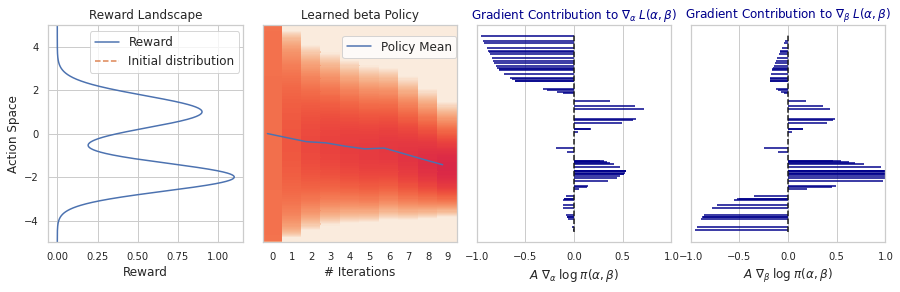

In [8]:
from scipy.stats import beta
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=False)
y1 = -5
y2 = 5
niters = 10
nbins = 201
x = np.linspace(y1, y2, 1000)
axes[0].set_ylim([y1, y2])
axes[0].set_ylabel('Action Space')
axes[0].set_title('Reward Landscape')
axes[0].set_xlabel('Reward')
axes[0].plot(np.vectorize(get_two_peak_reward)(x), x,
             linestyle='-', label='Reward', alpha=1)
axes[0].plot(3 * beta(0,1).pdf(x), x,
             linestyle='--', label='Initial distribution', alpha=1)
axes[1].set_ylim([y1, y2])
ax1_twin = axes[1].twinx()
ax1_twin.set_ylim([y1, y2])
x = np.linspace(y1, y2, nbins)
binwidth = (x[1]-x[0])
heatmap = np.zeros((niters, nbins))
for i in range(niters):
    a = filter_df(data_beta, iter=i, method='Clipping')['pd_param_0_mean'].values.item()
    b = filter_df(data_beta, iter=i, method='Clipping')['pd_param_1_mean'].values.item()
    rv = beta(a, b, loc=y1, scale=y2-y1)
    heatmap[i, :] = np.log(1e-6 + rv.cdf(x + binwidth/2) - rv.cdf(x - binwidth/2))
sns.heatmap(np.flip(heatmap.T, axis=0), ax=axes[1], square=False, cmap=sns.cm.rocket_r, vmin=-8, vmax=1.0,
            cbar=False, annot=False)
ax1_twin.plot(data_beta[(data_beta.method == 'Clipping') & (data_beta.iter < niters)].iter + 0.25,
              data_beta[(data_beta.method == 'Clipping') & (data_beta.iter < niters)]['mean'],
              label='Policy Mean')
axes[1].get_yaxis().set_ticks([])
axes[1].set_title('Learned beta Policy')
axes[1].set_xlabel('# Iterations')
ax1_twin.set_yticks([])


a = 1
b = 1
rvbeta = beta(a, b, scale=y2-y1, loc=y1)
x_betasamples = np.sort(rvbeta.rvs(64))
rewards = np.vectorize(get_two_peak_reward)(x_betasamples)
salpha_uniform = (x_betasamples - y1) / (y2-y1)
gradalpha = (rewards - np.mean(rewards)) / np.std(rewards) * salpha_uniform
print(np.sum(gradalpha))
ax_beta_grad = axes[2]
for i in range(len(x_betasamples)):
    ax_beta_grad.hlines(x_betasamples[i], 0, gradalpha[i], color='darkblue')
ax_beta_grad.set_xlabel(r'$A\;\nabla_{\alpha}\; \log\;\pi(\alpha,\beta)$',labelpad=5)
ax_beta_grad.set_title(r'Gradient Contribution to $\nabla_\alpha\;L(\alpha,\beta)$', color='darkblue')
ax_beta_grad.vlines(0, -5, 5, ls='--')
ax_beta_grad.set_xlim([-1, 1])
ax_beta_grad.set_yticks([])

sbeta_uniform = (y2 - x_betasamples) / (y2-y1)
gradbeta = (rewards - np.mean(rewards)) / np.std(rewards) * sbeta_uniform
print(np.sum(gradbeta))
ax_beta_grad = axes[3]
for i in range(len(x_betasamples)):
    ax_beta_grad.hlines(x_betasamples[i], 0, gradbeta[i], color='darkblue')
ax_beta_grad.set_xlabel(r'$A\;\nabla_{\beta}\; \log\;\pi(\alpha,\beta)$',labelpad=5)
ax_beta_grad.set_title(r'Gradient Contribution to $\nabla_\beta\;L(\alpha,\beta)$', color='darkblue')
ax_beta_grad.vlines(0, -5, 5, ls='--')
ax_beta_grad.set_xlim([-1, 1])
ax_beta_grad.set_yticks([])


fig.align_ylabels(axes)
fig.subplots_adjust(wspace=0.1)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.1, 0.75), ncol=1)
handles, labels = ax1_twin.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.38, 0.8), ncol=1)
plt.show()

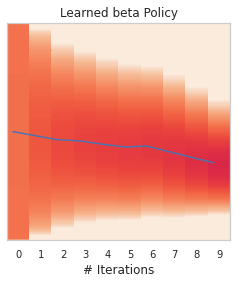

In [9]:
from scipy.stats import beta
fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharey=False)
axes = [None, axes]
y1 = -5
y2 = 5
niters = 10
nbins = 201
x = np.linspace(y1, y2, 1000)
axes[1].set_ylim([y1, y2])
ax1_twin = axes[1].twinx()
ax1_twin.set_ylim([y1, y2])
x = np.linspace(y1, y2, nbins)
binwidth = (x[1]-x[0])
heatmap = np.zeros((niters, nbins))
for i in range(niters):
    a = filter_df(data_beta, iter=i, method='Clipping')['pd_param_0_mean'].values.item()
    b = filter_df(data_beta, iter=i, method='Clipping')['pd_param_1_mean'].values.item()
    rv = beta(a, b, loc=y1, scale=y2-y1)
    heatmap[i, :] = np.log(1e-6 + rv.cdf(x + binwidth/2) - rv.cdf(x - binwidth/2))
#yticklabels = [xx.round(2) if i % 5 == 0 else ''  for i, xx in enumerate(x)]
sns.heatmap(np.flip(heatmap.T, axis=0), ax=axes[1], square=False, cmap=sns.cm.rocket_r, vmin=-8, vmax=1.0,
            cbar=False, annot=False)
ax1_twin.plot(data_beta[(data_beta.method == 'Clipping') & (data_beta.iter < niters)].iter + 0.25,
              data_beta[(data_beta.method == 'Clipping') & (data_beta.iter < niters)]['mean'],
              label='Policy Mean')
#ax1_twin.hlines(2.5, 0, 20, color='black')
axes[1].get_yaxis().set_ticks([])
axes[1].set_title('Learned beta Policy')
axes[1].set_xlabel('# Iterations')
ax1_twin.set_yticks([])
plt.show()